<a href="https://colab.research.google.com/github/mjhoover1/Robust_MAML/blob/main/Watermark_Attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download test.csv from Neel Google colab drive in Mini-ImageNetSplits

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [21]:
%mkdir images

In [22]:
%mv drive/MyDrive/mini-imagenet.zip images/

mv: cannot stat 'drive/MyDrive/mini-imagenet.zip': No such file or directory


In [4]:
!unzip images/mini-imagenet.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/n0679411000000879.jpg  
  inflating: images/n0679411000000880.jpg  
  inflating: images/n0679411000000881.jpg  
  inflating: images/n0679411000000882.jpg  
  inflating: images/n0679411000000885.jpg  
  inflating: images/n0679411000000894.jpg  
  inflating: images/n0679411000000895.jpg  
  inflating: images/n0679411000000897.jpg  
  inflating: images/n0679411000000898.jpg  
  inflating: images/n0679411000000899.jpg  
  inflating: images/n0679411000000900.jpg  
  inflating: images/n0679411000000901.jpg  
  inflating: images/n0679411000000902.jpg  
  inflating: images/n0679411000000904.jpg  
  inflating: images/n0679411000000905.jpg  
  inflating: images/n0679411000000909.jpg  
  inflating: images/n0679411000000912.jpg  
  inflating: images/n0679411000000913.jpg  
  inflating: images/n0679411000000916.jpg  
  inflating: images/n0679411000000918.jpg  
  inflating: images/n0679411000000919.jpg  
  inflating: images/n0679

In [23]:
%mkdir miniimagenet

mkdir: cannot create directory ‘miniimagenet’: File exists


In [24]:
%mv test.csv miniimagenet/

In [25]:
%mv images/ miniimagenet/

mv: cannot move 'images/' to 'miniimagenet/images': Directory not empty


In [8]:
%%writefile MiniImagenet.py

import os
import torch
from torch.utils.data import Dataset
from torchvision.transforms import transforms
import numpy as np
import collections
from PIL import Image
import csv
import random


class MiniImagenet(Dataset):
    """
    put mini-imagenet files as :
    root :
        |- images/*.jpg includes all imgeas
        |- train.csv
        |- test.csv
        |- val.csv
    NOTICE: meta-learning is different from general supervised learning, especially the concept of batch and set.
    batch: contains several sets
    sets: conains n_way * k_shot for meta-train set, n_way * n_query for meta-test set.
    """

    def __init__(self, root, mode, batchsz, n_way, k_shot, k_query, resize, startidx=0):
        """
        :param root: root path of mini-imagenet
        :param mode: train, val or test
        :param batchsz: batch size of sets, not batch of imgs
        :param n_way:
        :param k_shot:
        :param k_query: num of qeruy imgs per class
        :param resize: resize to
        :param startidx: start to index label from startidx
        """

        self.batchsz = batchsz  # batch of set, not batch of imgs
        self.n_way = n_way  # n-way
        self.k_shot = k_shot  # k-shot
        self.k_query = k_query  # for evaluation
        self.setsz = self.n_way * self.k_shot  # num of samples per set
        self.querysz = self.n_way * self.k_query  # number of samples per set for evaluation
        self.resize = resize  # resize to
        self.startidx = startidx  # index label not from 0, but from startidx
        print('shuffle DB :%s, b:%d, %d-way, %d-shot, %d-query, resize:%d' % (
        mode, batchsz, n_way, k_shot, k_query, resize))

        if mode == 'train':
            self.transform = transforms.Compose([lambda x: Image.open(x).convert('RGB'),
                                                 transforms.Resize((self.resize, self.resize)),
                                                 # transforms.RandomHorizontalFlip(),
                                                 # transforms.RandomRotation(5),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                                 ])
        else:
            self.transform = transforms.Compose([lambda x: Image.open(x).convert('RGB'),
                                                 transforms.Resize((self.resize, self.resize)),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                                 ])

        self.path = os.path.join(root, 'images')  # image path
        csvdata = self.loadCSV(os.path.join(root, mode + '.csv'))  # csv path
        self.data = []
        self.img2label = {}
        for i, (k, v) in enumerate(csvdata.items()):
            self.data.append(v)  # [[img1, img2, ...], [img111, ...]]
            self.img2label[k] = i + self.startidx  # {"img_name[:9]":label}
        self.cls_num = len(self.data)

        self.create_batch(self.batchsz)

    def loadCSV(self, csvf):
        """
        return a dict saving the information of csv
        :param splitFile: csv file name
        :return: {label:[file1, file2 ...]}
        """
        dictLabels = {}
        with open(csvf) as csvfile:
            csvreader = csv.reader(csvfile, delimiter=',')
            next(csvreader, None)  # skip (filename, label)
            for i, row in enumerate(csvreader):
                filename = row[0]
                label = row[1]
                # append filename to current label
                if label in dictLabels.keys():
                    dictLabels[label].append(filename)
                else:
                    dictLabels[label] = [filename]
        return dictLabels

    def create_batch(self, batchsz):
        """
        create batch for meta-learning.
        ×episode× here means batch, and it means how many sets we want to retain.
        :param episodes: batch size
        :return:
        """
        self.support_x_batch = []  # support set batch
        self.query_x_batch = []  # query set batch
        for b in range(batchsz):  # for each batch
            # 1.select n_way classes randomly
            selected_cls = np.random.choice(self.cls_num, self.n_way, False)  # no duplicate
            np.random.shuffle(selected_cls)
            support_x = []
            query_x = []
            for cls in selected_cls:
                # 2. select k_shot + k_query for each class

                selected_imgs_idx = np.random.choice(len(self.data[cls]), self.k_shot + self.k_query, False)
                np.random.shuffle(selected_imgs_idx)
                indexDtrain = np.array(selected_imgs_idx[:self.k_shot])  # idx for Dtrain
                indexDtest = np.array(selected_imgs_idx[self.k_shot:])  # idx for Dtest
                support_x.append(
                    np.array(self.data[cls])[indexDtrain].tolist())  # get all images filename for current Dtrain
                query_x.append(np.array(self.data[cls])[indexDtest].tolist())

            # shuffle the correponding relation between support set and query set
            random.shuffle(support_x)
            random.shuffle(query_x)

            self.support_x_batch.append(support_x)  # append set to current sets
            self.query_x_batch.append(query_x)  # append sets to current sets

    def __getitem__(self, index):
        """
        index means index of sets, 0<= index <= batchsz-1
        :param index:
        :return:
        """
        # [setsz, 3, resize, resize]
        support_x = torch.FloatTensor(self.setsz, 3, self.resize, self.resize)
        # [setsz]
        support_y = np.zeros((self.setsz), dtype=np.int)
        # [querysz, 3, resize, resize]
        query_x = torch.FloatTensor(self.querysz, 3, self.resize, self.resize)
        # [querysz]
        query_y = np.zeros((self.querysz), dtype=np.int)

        flatten_support_x = [os.path.join(self.path, item) for sublist in self.support_x_batch[index] for item in sublist]
        # filename:n0153282900000005.jpg, the first 9 characters treated as label

        support_y = np.array([self.img2label[item[:9]] for sublist in self.support_x_batch[index] for item in sublist]).astype(np.int32)

        flatten_query_x = [os.path.join(self.path, item) for sublist in self.query_x_batch[index] for item in sublist]
        query_y = np.array([self.img2label[item[:9]] for sublist in self.query_x_batch[index] for item in sublist]).astype(np.int32)

        # print('global:', support_y, query_y)
        # support_y: [setsz]
        # query_y: [querysz]
        # unique: [n-way], sorted
        unique = np.unique(support_y)
        random.shuffle(unique)
        # relative means the label ranges from 0 to n-way
        support_y_relative = np.zeros(self.setsz)
        query_y_relative = np.zeros(self.querysz)
        for idx, l in enumerate(unique):
            support_y_relative[support_y == l] = idx
            query_y_relative[query_y == l] = idx

        # print('relative:', support_y_relative, query_y_relative)

        for i, path in enumerate(flatten_support_x):
            support_x[i] = self.transform(path)

        for i, path in enumerate(flatten_query_x):
            query_x[i] = self.transform(path)
        # print(support_set_y)
        # return support_x, torch.LongTensor(support_y), query_x, torch.LongTensor(query_y)

        return support_x, torch.LongTensor(support_y_relative), query_x, torch.LongTensor(query_y_relative)

    def __len__(self):
        # as we have built up to batchsz of sets, you can sample some small batch size of sets.
        return self.batchsz


if __name__ == '__main__':
    # the following episode is to view one set of images via tensorboard.
    from torchvision.utils import make_grid
    from matplotlib import pyplot as plt
    from tensorboardX import SummaryWriter
    import time

    plt.ion()

    tb = SummaryWriter('runs', 'mini-imagenet')
    mini = MiniImagenet('../mini-imagenet/', mode='train', n_way=5, k_shot=1, k_query=1, batchsz=1000, resize=168)

    for i, set_ in enumerate(mini):
        # support_x: [k_shot*n_way, 3, 84, 84]
        support_x, support_y, query_x, query_y = set_

        support_x = make_grid(support_x, nrow=2)
        query_x = make_grid(query_x, nrow=2)

        plt.figure(1)
        plt.imshow(support_x.transpose(2, 0).numpy())
        plt.pause(0.5)
        plt.figure(2)
        plt.imshow(query_x.transpose(2, 0).numpy())
        plt.pause(0.5)

        tb.add_image('support_x', support_x)
        tb.add_image('query_x', query_x)

        time.sleep(5)

    tb.close()

Writing MiniImagenet.py


In [9]:
import torch
from    torch import nn
from    torch.nn import functional as F
import  numpy as np
from MiniImagenet import MiniImagenet
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision.utils import make_grid

## Create the config and get the model

### Learner

In [10]:
class Learner(nn.Module):
    """

    """

    def __init__(self, config, imgc, imgsz):
        """

        :param config: network config file, type:list of (string, list)
        :param imgc: 1 or 3
        :param imgsz:  28 or 84
        """
        super(Learner, self).__init__()


        self.config = config

        # this dict contains all tensors needed to be optimized
        self.vars = nn.ParameterList()
        # running_mean and running_var
        self.vars_bn = nn.ParameterList()

        for i, (name, param) in enumerate(self.config):
            if name is 'conv2d':
                # [ch_out, ch_in, kernelsz, kernelsz]
                w = nn.Parameter(torch.ones(*param[:4]))
                # gain=1 according to cbfin's implementation
                torch.nn.init.kaiming_normal_(w)
                self.vars.append(w)
                # [ch_out]
                self.vars.append(nn.Parameter(torch.zeros(param[0])))

            elif name is 'convt2d':
                # [ch_in, ch_out, kernelsz, kernelsz, stride, padding]
                w = nn.Parameter(torch.ones(*param[:4]))
                # gain=1 according to cbfin's implementation
                torch.nn.init.kaiming_normal_(w)
                self.vars.append(w)
                # [ch_in, ch_out]
                self.vars.append(nn.Parameter(torch.zeros(param[1])))

            elif name is 'linear':
                # [ch_out, ch_in]
                w = nn.Parameter(torch.ones(*param))
                # gain=1 according to cbfinn's implementation
                torch.nn.init.kaiming_normal_(w)
                self.vars.append(w)
                # [ch_out]
                self.vars.append(nn.Parameter(torch.zeros(param[0])))

            elif name is 'bn':
                # [ch_out]
                w = nn.Parameter(torch.ones(param[0]))
                self.vars.append(w)
                # [ch_out]
                self.vars.append(nn.Parameter(torch.zeros(param[0])))

                # must set requires_grad=False
                running_mean = nn.Parameter(torch.zeros(param[0]), requires_grad=False)
                running_var = nn.Parameter(torch.ones(param[0]), requires_grad=False)
                self.vars_bn.extend([running_mean, running_var])


            elif name in ['tanh', 'relu', 'upsample', 'avg_pool2d', 'max_pool2d',
                          'flatten', 'reshape', 'leakyrelu', 'sigmoid']:
                continue
            else:
                raise NotImplementedError






    def extra_repr(self):
        info = ''

        for name, param in self.config:
            if name is 'conv2d':
                tmp = 'conv2d:(ch_in:%d, ch_out:%d, k:%dx%d, stride:%d, padding:%d)'\
                      %(param[1], param[0], param[2], param[3], param[4], param[5],)
                info += tmp + '\n'

            elif name is 'convt2d':
                tmp = 'convTranspose2d:(ch_in:%d, ch_out:%d, k:%dx%d, stride:%d, padding:%d)'\
                      %(param[0], param[1], param[2], param[3], param[4], param[5],)
                info += tmp + '\n'

            elif name is 'linear':
                tmp = 'linear:(in:%d, out:%d)'%(param[1], param[0])
                info += tmp + '\n'

            elif name is 'leakyrelu':
                tmp = 'leakyrelu:(slope:%f)'%(param[0])
                info += tmp + '\n'


            elif name is 'avg_pool2d':
                tmp = 'avg_pool2d:(k:%d, stride:%d, padding:%d)'%(param[0], param[1], param[2])
                info += tmp + '\n'
            elif name is 'max_pool2d':
                tmp = 'max_pool2d:(k:%d, stride:%d, padding:%d)'%(param[0], param[1], param[2])
                info += tmp + '\n'
            elif name in ['flatten', 'tanh', 'relu', 'upsample', 'reshape', 'sigmoid', 'use_logits', 'bn']:
                tmp = name + ':' + str(tuple(param))
                info += tmp + '\n'
            else:
                raise NotImplementedError

        return info



    def forward(self, x, vars=None, bn_training=True):
        """
        This function can be called by finetunning, however, in finetunning, we dont wish to update
        running_mean/running_var. Thought weights/bias of bn is updated, it has been separated by fast_weights.
        Indeed, to not update running_mean/running_var, we need set update_bn_statistics=False
        but weight/bias will be updated and not dirty initial theta parameters via fast_weiths.
        :param x: [b, 1, 28, 28]
        :param vars:
        :param bn_training: set False to not update
        :return: x, loss, likelihood, kld
        """

        if vars is None:
            vars = self.vars

        idx = 0
        bn_idx = 0

        for name, param in self.config:
            if name is 'conv2d':
                w, b = vars[idx], vars[idx + 1]
                # remember to keep synchrozied of forward_encoder and forward_decoder!
                x = F.conv2d(x, w, b, stride=param[4], padding=param[5])
                idx += 2
                # print(name, param, '\tout:', x.shape)
            elif name is 'convt2d':
                w, b = vars[idx], vars[idx + 1]
                # remember to keep synchrozied of forward_encoder and forward_decoder!
                x = F.conv_transpose2d(x, w, b, stride=param[4], padding=param[5])
                idx += 2
                # print(name, param, '\tout:', x.shape)
            elif name is 'linear':
                w, b = vars[idx], vars[idx + 1]
                x = F.linear(x, w, b)
                idx += 2
                # print('forward:', idx, x.norm().item())
            elif name is 'bn':
                w, b = vars[idx], vars[idx + 1]
                running_mean, running_var = self.vars_bn[bn_idx], self.vars_bn[bn_idx+1]
                x = F.batch_norm(x, running_mean, running_var, weight=w, bias=b, training=bn_training)
                idx += 2
                bn_idx += 2

            elif name is 'flatten':
                # print(x.shape)
                x = x.view(x.size(0), -1)
            elif name is 'reshape':
                # [b, 8] => [b, 2, 2, 2]
                x = x.view(x.size(0), *param)
            elif name is 'relu':
                x = F.relu(x, inplace=param[0])
            elif name is 'leakyrelu':
                x = F.leaky_relu(x, negative_slope=param[0], inplace=param[1])
            elif name is 'tanh':
                x = F.tanh(x)
            elif name is 'sigmoid':
                x = torch.sigmoid(x)
            elif name is 'upsample':
                x = F.upsample_nearest(x, scale_factor=param[0])
            elif name is 'max_pool2d':
                x = F.max_pool2d(x, param[0], param[1], param[2])
            elif name is 'avg_pool2d':
                x = F.avg_pool2d(x, param[0], param[1], param[2])

            else:
                raise NotImplementedError

        # make sure variable is used properly
        assert idx == len(vars)
        assert bn_idx == len(self.vars_bn)


        return x


    def zero_grad(self, vars=None):
        """

        :param vars:
        :return:
        """
        with torch.no_grad():
            if vars is None:
                for p in self.vars:
                    if p.grad is not None:
                        p.grad.zero_()
            else:
                for p in vars:
                    if p.grad is not None:
                        p.grad.zero_()

    def parameters(self):
        """
        override this function since initial parameters will return with a generator.
        :return:
        """
        return self.vars

In [11]:
n_way = 5
miniImgNet_config = [
        ('conv2d', [32, 3, 3, 3, 1, 0]),
        ('relu', [True]),
        ('bn', [32]),
        ('max_pool2d', [2, 2, 0]),
        ('conv2d', [32, 32, 3, 3, 1, 0]),
        ('relu', [True]),
        ('bn', [32]),
        ('max_pool2d', [2, 2, 0]),
        ('conv2d', [32, 32, 3, 3, 1, 0]),
        ('relu', [True]),
        ('bn', [32]),
        ('max_pool2d', [2, 2, 0]),
        ('conv2d', [32, 32, 3, 3, 1, 0]),
        ('relu', [True]),
        ('bn', [32]),
        ('max_pool2d', [2, 1, 0]),
        ('flatten', []),
        ('linear', [n_way, 32 * 5 * 5])
    ]

In [12]:
import  torch
from    torch import nn
from    torch import optim
from    torch.nn import functional as F
from    torch.utils.data import TensorDataset, DataLoader
from    torch import optim
import  numpy as np

# from    learner import Learner
from    copy import deepcopy



class Meta(nn.Module):
    """
    Meta Learner
    """
    def __init__(self,config):
        """

        :param args:
        """
        super(Meta, self).__init__()

        self.update_lr = 0.01#args.update_lr
        self.meta_lr = 0.001#args.meta_lr
        self.n_way = 5#args.n_way
        self.k_spt = 5#args.k_spt
        self.k_qry = 5#args.k_qry
        self.task_num = 4#args.task_num
        self.update_step = 5#args.update_step
        self.update_step_test = 10#args.update_step_test


        self.net = Learner(config, 3, 84)
        self.meta_optim = optim.Adam(self.net.parameters(), lr=self.meta_lr)




    def clip_grad_by_norm_(self, grad, max_norm):
        """
        in-place gradient clipping.
        :param grad: list of gradients
        :param max_norm: maximum norm allowable
        :return:
        """

        total_norm = 0
        counter = 0
        for g in grad:
            param_norm = g.data.norm(2)
            total_norm += param_norm.item() ** 2
            counter += 1
        total_norm = total_norm ** (1. / 2)

        clip_coef = max_norm / (total_norm + 1e-6)
        if clip_coef < 1:
            for g in grad:
                g.data.mul_(clip_coef)

        return total_norm/counter


    def forward(self, x_spt, y_spt, x_qry, y_qry):
        """

        :param x_spt:   [b, setsz, c_, h, w]
        :param y_spt:   [b, setsz]
        :param x_qry:   [b, querysz, c_, h, w]
        :param y_qry:   [b, querysz]
        :return:
        """
        task_num, setsz, c_, h, w = x_spt.size()
        querysz = x_qry.size(1)

        losses_q = [0 for _ in range(self.update_step + 1)]  # losses_q[i] is the loss on step i
        corrects = [0 for _ in range(self.update_step + 1)]


        for i in range(task_num):

            # 1. run the i-th task and compute loss for k=0
            logits = self.net(x_spt[i], vars=None, bn_training=True)
            loss = F.cross_entropy(logits, y_spt[i])
            grad = torch.autograd.grad(loss, self.net.parameters())
            fast_weights = list(map(lambda p: p[1] - self.update_lr * p[0], zip(grad, self.net.parameters())))

            # this is the loss and accuracy before first update
            with torch.no_grad():
                # [setsz, nway]
                logits_q = self.net(x_qry[i], self.net.parameters(), bn_training=True)
                loss_q = F.cross_entropy(logits_q, y_qry[i])
                losses_q[0] += loss_q

                pred_q = F.softmax(logits_q, dim=1).argmax(dim=1)
                correct = torch.eq(pred_q, y_qry[i]).sum().item()
                corrects[0] = corrects[0] + correct

            # this is the loss and accuracy after the first update
            with torch.no_grad():
                # [setsz, nway]
                logits_q = self.net(x_qry[i], fast_weights, bn_training=True)
                loss_q = F.cross_entropy(logits_q, y_qry[i])
                losses_q[1] += loss_q
                # [setsz]
                pred_q = F.softmax(logits_q, dim=1).argmax(dim=1)
                correct = torch.eq(pred_q, y_qry[i]).sum().item()
                corrects[1] = corrects[1] + correct

            for k in range(1, self.update_step):
                # 1. run the i-th task and compute loss for k=1~K-1
                logits = self.net(x_spt[i], fast_weights, bn_training=True)
                loss = F.cross_entropy(logits, y_spt[i])
                # 2. compute grad on theta_pi
                grad = torch.autograd.grad(loss, fast_weights)
                # 3. theta_pi = theta_pi - train_lr * grad
                fast_weights = list(map(lambda p: p[1] - self.update_lr * p[0], zip(grad, fast_weights)))

                logits_q = self.net(x_qry[i], fast_weights, bn_training=True)
                # loss_q will be overwritten and just keep the loss_q on last update step.
                loss_q = F.cross_entropy(logits_q, y_qry[i])
                losses_q[k + 1] += loss_q

                with torch.no_grad():
                    pred_q = F.softmax(logits_q, dim=1).argmax(dim=1)
                    correct = torch.eq(pred_q, y_qry[i]).sum().item()  # convert to numpy
                    corrects[k + 1] = corrects[k + 1] + correct



        # end of all tasks
        # sum over all losses on query set across all tasks
        loss_q = losses_q[-1] / task_num

        # optimize theta parameters
        self.meta_optim.zero_grad()
        loss_q.backward()
        # print('meta update')
        # for p in self.net.parameters()[:5]:
        # 	print(torch.norm(p).item())
        self.meta_optim.step()


        accs = np.array(corrects) / (querysz * task_num)

        return accs


    def finetunning(self, x_spt, y_spt, x_qry, y_qry):
        """

        :param x_spt:   [setsz, c_, h, w]
        :param y_spt:   [setsz]
        :param x_qry:   [querysz, c_, h, w]
        :param y_qry:   [querysz]
        :return:
        """
        assert len(x_spt.shape) == 4

        querysz = x_qry.size(0)

        corrects = [0 for _ in range(self.update_step_test + 1)]

        # in order to not ruin the state of running_mean/variance and bn_weight/bias
        # we finetunning on the copied model instead of self.net
        net = deepcopy(self.net)

        # 1. run the i-th task and compute loss for k=0
        logits = net(x_spt)
        loss = F.cross_entropy(logits, y_spt)
        grad = torch.autograd.grad(loss, net.parameters())
        fast_weights = list(map(lambda p: p[1] - self.update_lr * p[0], zip(grad, net.parameters())))

        # this is the loss and accuracy before first update
        with torch.no_grad():
            # [setsz, nway]
            logits_q = net(x_qry, net.parameters(), bn_training=True)
            # [setsz]
            pred_q = F.softmax(logits_q, dim=1).argmax(dim=1)
            # scalar
            correct = torch.eq(pred_q, y_qry).sum().item()
            corrects[0] = corrects[0] + correct

        # this is the loss and accuracy after the first update
        with torch.no_grad():
            # [setsz, nway]
            logits_q = net(x_qry, fast_weights, bn_training=True)
            # [setsz]
            pred_q = F.softmax(logits_q, dim=1).argmax(dim=1)
            # scalar
            correct = torch.eq(pred_q, y_qry).sum().item()
            corrects[1] = corrects[1] + correct

        for k in range(1, self.update_step_test):
            # 1. run the i-th task and compute loss for k=1~K-1
            logits = net(x_spt, fast_weights, bn_training=True)
            loss = F.cross_entropy(logits, y_spt)
            # 2. compute grad on theta_pi
            grad = torch.autograd.grad(loss, fast_weights)
            # 3. theta_pi = theta_pi - train_lr * grad
            fast_weights = list(map(lambda p: p[1] - self.update_lr * p[0], zip(grad, fast_weights)))

            logits_q = net(x_qry, fast_weights, bn_training=True)
            # loss_q will be overwritten and just keep the loss_q on last update step.
            loss_q = F.cross_entropy(logits_q, y_qry)

            with torch.no_grad():
                pred_q = F.softmax(logits_q, dim=1).argmax(dim=1)
                correct = torch.eq(pred_q, y_qry).sum().item()  # convert to numpy
                corrects[k + 1] = corrects[k + 1] + correct


        del net

        accs = np.array(corrects) / querysz

        return accs


        # This finetunning also takes the target idx to get the prediction for it so it can be returned.
    def finetunning_more_detail(self, x_spt, y_spt, x_qry, y_qry, target_idx, target_class):
        """

        :param x_spt:   [setsz, c_, h, w]
        :param y_spt:   [setsz]
        :param x_qry:   [querysz, c_, h, w]
        :param y_qry:   [querysz]
        :return:
        """
        assert len(x_spt.shape) == 4 # Throw exception if the support set isn't 
        pred_correct = 0

        querysz = x_qry.size(0) # Returns the number 
        # print("querysz ", querysz)

        corrects = [0 for _ in range(self.update_step_test + 1)] 
        # print("corrects ", corrects)

        # in order to not ruin the state of running_mean/variance and bn_weight/bias
        # we finetunning on the copied model instead of self.net
        net = deepcopy(self.net)

        # 1. run the i-th task and compute loss for k=0
        logits = net(x_spt) # predictions for the support set
        # print("logits ", logits)
        loss = F.cross_entropy(logits, y_spt) # loss for the support predictions and class labels
        grad = torch.autograd.grad(loss, net.parameters()) # The gradient of the loss for the support set
        fast_weights = list(map(lambda p: p[1] - self.update_lr * p[0], zip(grad, net.parameters()))) # Take gradient step from the loss on the support set on copied net.

        # this is the loss and accuracy before first update
        with torch.no_grad():
            # [setsz, nway]
            logits_q = net(x_qry, net.parameters(), bn_training=True)
            # [setsz]
            pred_q = F.softmax(logits_q, dim=1).argmax(dim=1)
            # scalar
            correct = torch.eq(pred_q, y_qry).sum().item()
            corrects[0] = corrects[0] + correct

        # this is the loss and accuracy after the first update
        with torch.no_grad():
            # [setsz, nway]
            logits_q = net(x_qry, fast_weights, bn_training=True)
            # [setsz]
            pred_q = F.softmax(logits_q, dim=1).argmax(dim=1)
            # scalar
            correct = torch.eq(pred_q, y_qry).sum().item()
            corrects[1] = corrects[1] + correct

        for k in range(1, self.update_step_test):
            # 1. run the i-th task and compute loss for k=1~K-1
            logits = net(x_spt, fast_weights, bn_training=True)
            loss = F.cross_entropy(logits, y_spt)
            # 2. compute grad on theta_pi
            grad = torch.autograd.grad(loss, fast_weights)
            # 3. theta_pi = theta_pi - train_lr * grad
            fast_weights = list(map(lambda p: p[1] - self.update_lr * p[0], zip(grad, fast_weights)))

            logits_q = net(x_qry, fast_weights, bn_training=True)
            # loss_q will be overwritten and just keep the loss_q on last update step.
            loss_q = F.cross_entropy(logits_q, y_qry)

            with torch.no_grad():
                pred_q = F.softmax(logits_q, dim=1).argmax(dim=1)
                # If it's the last update step and target class is equal to the predicted target
                if k == self.update_step_test - 1 and target_class == int(pred_q[target_idx]):
                  pred_correct = 1
                actual_pred = int(pred_q[target_idx]) # Actual prediction

                correct = torch.eq(pred_q, y_qry).sum().item()  # convert to numpy
                corrects[k + 1] = corrects[k + 1] + correct


        del net

        accs = np.array(corrects) / querysz
        # print("corrects ", corrects[-1])

        return accs, pred_correct, actual_pred




def main():
    pass


if __name__ == '__main__':
    main()


-----

### Here start Poisoning

Download model_test_empty from Github and place in local files.

In [26]:
model = Learner(miniImgNet_config,3,84)
maml = Meta(miniImgNet_config)
model.load_state_dict(torch.load(f"Leaner_OBJ_MiniImagenet_n_way_5_k_shot_5_acc_0.60546875_dateMMDDYYY_10272021",map_location=torch.device('cpu')))
maml.net = model
# model_small.train()

In [27]:
mini_test = MiniImagenet('miniimagenet/', mode='test', n_way=5, k_shot=5,
                         k_query=15,
                         batchsz=100, resize=84)

shuffle DB :test, b:100, 5-way, 5-shot, 15-query, resize:84


In [28]:
# this function poisons a specific support image using a target query image
def poison_image(support_img, target_img, opacity, show=False):
    """
    Recursively retrieves the autograd graph for a particular tensor.
    # Arguments
        support_img: Image from the support set.
        target_img: Specific img from the query set, the target img to be misclassified.
        opacity: Amount of opacity to for target image, so base opacity is 1-opacity.
        show: If true will show support, target, and poisoned image.
    # Returns
        poisoned_img: A poisoned support img with target watermark
    """ 
    # Testing with 50%
    poisoned_img = opacity*target_img + (1-opacity)*support_img # opacity of target image for overlay on base images
    if show:
      show_img(support_img, 'Support Img')
      show_img(target_img, 'Target Img')
      show_img(poisoned_img, 'Poisoned Img')
    return poisoned_img

In [29]:
# Shows a given image 
def show_img(img, title, fig_dim = [10, 10]):
    """
    Recursively retrieves the autograd graph for a particular tensor.
    # Arguments
        img: Given image to show.
        fig_dim: Dimensions of the figure for examples [10, 10].
        title: The title desired for the shown image.
    # Returns
        Void
    # Side effect
        Shows a given image
    """ 
    plt.figure(figsize=fig_dim)
    plt.axis('off')
    plt.title(title)
    plt.imshow(img.permute(1, 2, 0))
    plt.show()

In [30]:
# Shows a given image group on a grid 
def show_grid(img_group, title, row_size, debug = False, fig_dim = [10, 10]):
    """
    Recursively retrieves the autograd graph for a particular tensor.
    # Arguments
        img: Given image group to show.
        title: The title desired for the shown image.
        fig_dim: Dimensions of the figure for examples [10, 10].
    # Returns
        Void
    # Side effect
        Shows a given image
    """ 
    grid_img = make_grid(img_group.squeeze(), nrow=row_size) # make grid (row_size and as many columns as possible) to display our n images
    if debug:
      print('images.shape:', img_group.shape)
      print('grid shape: ', grid_img.shape)
    show_img(grid_img, title, fig_dim)

In [31]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cpu device


In [32]:
#Forward pass
def forward_e2e(img,target,lr, model):
  base_tensor = img.reshape(-1,3,84,84) # Reshape (#)
  target_tensor = target.reshape(-1,3,84,84)
  base_tensor.requires_grad = True # Turning on gradients need to be computed
  target.requires_grad = False # Turning off gradients don't need to be computed
  model.eval() # Calling eval for evaluation preparation
  # cnn.load_state_dict(torch.load(PATH)), we already did this
  f_t = model.forward(target.reshape(-1,3,84,84)) # Take forward step of target image to get logits
  f_x = model.forward(base_tensor) # Take forward step of base image to get logits
  loss = torch.norm(f_t-f_x, 2)**2 # Get the difference in the gradients of target and base image
  loss.backward() # Taking the gradient of the difference in the target and base img
  # print(loss)
  base_tensor_step = base_tensor - lr*base_tensor.grad.data # Doing a gradient descent on base img
  base_tensor.grad.data.zero_() # reseting the gradient 
  return base_tensor_step.reshape(3,84,84).detach()

def backward(img,base_img,beta,lr):
    #img  -= beta*(img - base_img)
    img = (img + lr*beta*base_img)/(1+beta*lr)
    return img 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


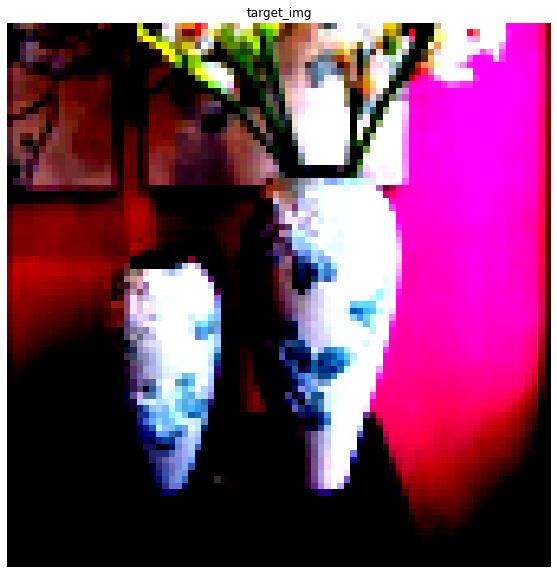

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


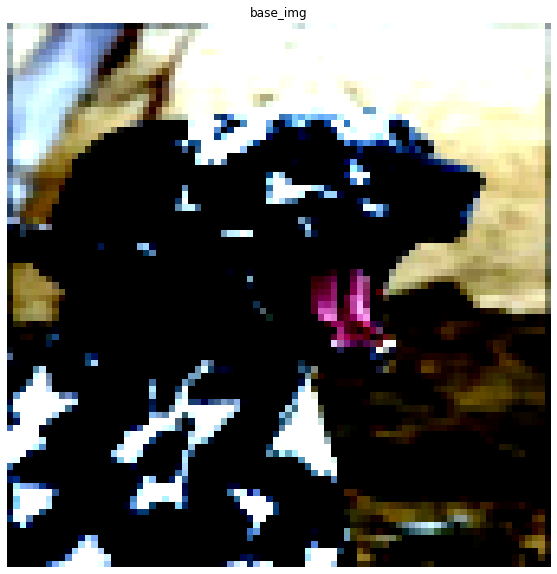

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 84, 84])


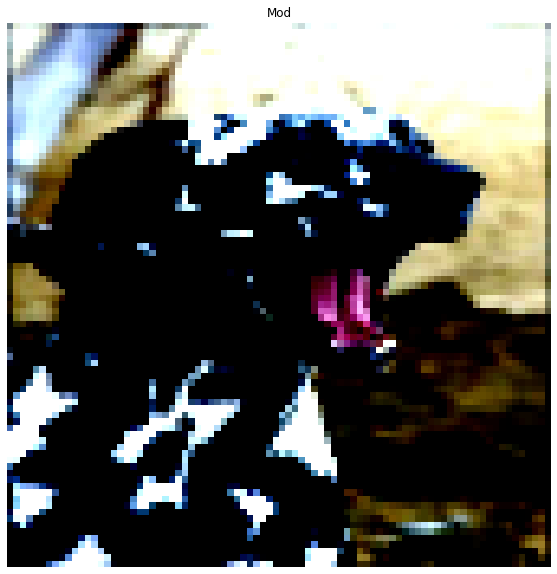

Iteration 1: Target opacity: 0, Labeled correctly: 0.6, Correctly Predicted Target: False, Base class predicted: False
Iteration 1: Target opacity: 0.05, Labeled correctly: 0.6, Correctly Predicted Target: False, Base class predicted: False


KeyboardInterrupt: ignored

In [33]:
from random import randrange
import  numpy as np
import copy

# Sets seed for reproduciability
torch.manual_seed(222)
torch.cuda.manual_seed_all(222)
np.random.seed(222)

# Creates a dataloader using the MiniImageNet class 
db_test = DataLoader(mini_test, 1, shuffle=True, num_workers=0, pin_memory=True)
baseline_accs_all_test = [] # holds the baseline accuracies for all tasks
clean_accs_all_test = [] # holds the accuracies for all clean tasks
poison_accs_all_test = [] # holds the accuracies for all poisoned tasks
i = 0 # counter for display
# base_and_target_imgs = {}
display = False # Determines if the support and query set should be displayed
opacity = [0, .05, .1, .15, .2, .25, .3, .35, .4, .45, .5] # A list for all opacities
final_accs = {} # A dictionary to hold final accuracies (key = opacity, value = accuracies for task using opacity)
final_target_predictions = {} # A dictionary to hold final predictions for target img
final_base_predictions = {} # A dictionary to hold if the base class was predicted over target class
# Initialize all keys (opacities) to an empty list
for o in opacity:
    final_accs[o] = []
    final_target_predictions[o] = []
    final_base_predictions[o] = []
    
# Traverse through dataloader where each iteration is a Task (support set, Query set)
for x_spt, y_spt, x_qry, y_qry in db_test:
  if display: # displays support set and query set
    # plot support set
    show_grid(x_spt, 'Support Set', 5)
    print("y_spt", y_spt)
    # plot query set
    show_grid(x_qry, 'Query Set', 15, fig_dim=[25, 25])
    print("y_qry", y_qry)
  # squeeze - Returns a tensor with all the dimensions of input of size 1 removed.
  x_spt, y_spt, x_qry, y_qry = x_spt.squeeze(0), y_spt.squeeze(0), \
                                x_qry.squeeze(0), y_qry.squeeze(0)
  # Randomly select a class for target image
  unique_classes = list(set([y.item() for y in y_spt])) # creates a set of the unique classes in support set then converts it to a list to be able to index it.
  target_class_idx = randrange(len(unique_classes)) # randomly generate a class index from 0 to len of unique classes
  target_class = unique_classes[target_class_idx] # This is a randomly generated target class
  # Randomly select a class for base image which is can't include target's class
  unique_classes.remove(target_class) # Remove the target class from unique classes so base and target are of different classes.
  base_class_idx = randrange(len(unique_classes)) # randomly generate a class index from 0 to len of unique classes
  base_class = unique_classes[base_class_idx] # This is a randomly generated base class

  # Get a specific target image from the query set of the found target class
  arr = np.array(y_qry) # convert y_qry to a tensor
  def condition(x, class_num): return x == class_num # This define a function to test if the element is the class number
  bool_arr = condition(arr, target_class) # Returns a boolean array where on items of the class number are True
  target_indices = np.where(bool_arr)[0] # Will return the indices where the condition is true, i.e., the indices where the class is equal to the class number.
  target_index = target_indices[randrange(len(target_indices))] # randomly select a class index from 0 to len of unique classes
  target = x_qry[target_index] # The target image which will be used to watermark the base img


  # Get a specific base image from the support set of the found base class
  arr = np.array(y_spt) # convert y_spt to a tensor
  bool_arr = condition(arr, base_class) # Returns a boolean array where on items of the class number are True
  base_indices = np.where(bool_arr)[0] # Will return the indices where the condition is true, i.e., the indices where the class is equal to the class number.
  base_index = base_indices[randrange(len(base_indices))] # randomly select a class index from 0 to len of unique classes
  base = x_spt[base_index] # The base image which will be used to watermark the base img
  if display:
    print("target_class",target_class)
    print("unique_classes",unique_classes)
    print("base_class", base_class)
    print("target_indices", target_indices)
    print("target_index", target_index)
    print("base_indices", base_indices)
    print("base_index", base_index)
    show_img(target, "target_img")
    show_img(base, "base_img")
  show_img(target, "target_img")
  show_img(base, "base_img")
  mod = forward_e2e(base,target,.001, model)
  print(mod.shape)
  show_img(mod, "Mod")
  exit(0)

  # Calculate base line accuracy
  # baseline_accs, target_prediction = maml.finetunning_more_detail(x_spt, y_spt, x_qry, y_qry, target_index, target_class) # Calculate baseline accuracy for Task i
  # baseline_accs_all_test.append(baseline_accs) # Append baseline accuracy for Task i

  # Apply the watermark poison
  base = copy.deepcopy(base) # Make a deep copy of base so it will always have no opacity
  i += 1
  for o in opacity: # for each opacity
    x_spt[base_index] = poison_image(base, target, o)  # poison the base img in the support set using target and opacity
    if display:
      show_img(x_spt[base_index], "Watermarked Image")
    # Calculate baseline accuracy for Task i and opacity o, returns accuracy and target prediction whether the target prediction was correctly predicted, and the actual prediction.
    curr_acc, target_prediction, actual_prediction = maml.finetunning_more_detail(x_spt, y_spt, x_qry, y_qry, target_index, target_class)  
    final_accs[o].append(curr_acc) # Add the final accuracies for the current opacity key
    final_target_predictions[o].append(target_prediction) # Add the final prediction for the current opacity key
    target_result = base_class == actual_prediction # Whether the actual prediction was the base class for the target image
    final_base_predictions[o].append(int(target_result))

    print("Iteration " + str(i) + ": Target opacity: " + str(o) + ", Labeled correctly: " + str(curr_acc[-1]) + ", Correctly Predicted Target: " + str(bool(target_prediction)) + ", Base class predicted: " + str(target_result))

  # spt_idx = np.argsort(y_spt.numpy())[0]
  # qry_idx = np.argsort(y_qry.numpy())[-1]
  # base = copy.deepcopy(x_spt[spt_idx])
  # target = x_qry[qry_idx]
  # x_qry = target
  # y_qry = y_qry[qry_idx]
  # x_qry = x_qry.reshape(1, 3, 84, 84)
  # y_qry = y_qry.reshape(1)
  # i += 1
  # for o in opacity:
  #   x_spt[spt_idx] = poison_image(base, target, o)
  #   curr_acc = maml.finetunning(x_spt, y_spt, x_qry, y_qry)
  #   final_accs[o].append(curr_acc)
  #   print(i, "Target opacity", o, " Labeled correctly: ", curr_acc[-1])
  #   print(i, ": ", accs[-1]) # original


# original
# accs = np.array(accs_all_test).mean(axis=0).astype(np.float16)
# print(accs)

for key, item in final_accs.items():
  curr_acc = np.array(item).mean(axis=0).astype(np.float16)
  print("Target opacity:", key, "accuracies:", curr_acc)

for key, item in final_target_predictions.items():
  target_predictions = np.array(item).mean(axis=0).astype(np.float16)
  print("Target opacity:", key, "target_predictions:", target_predictions)

for key, item in final_base_predictions.items():
  base_predictions = np.array(item).mean(axis=0).astype(np.float16)
  print("Target opacity:", key, "base_predictions:", base_predictions)

In [ ]:
    # It seems like since the query set and support set are randomly shuffled this won't work
    # The reason is that it's possible the first img in the support set is of the same class 
    # as the last image in the query set.
    # new_image = poison_image(x_spt[0], x_qry[-1], .8, True)
    # support_idx = randrange(len(x_spt)) # 0 - 24
    # query_idx = randrange(len(x_qry)) # 0 - 74
    # while y_spt[support_idx] == y_qry[query_idx]:
    #   support_idx = randrange(len(x_spt)) # 0 - 24
    #   query_idx = randrange(len(x_qry)) # 0 - 74



    # clean_accs = maml.finetunning(x_spt, y_spt, x_qry, y_qry)
    # clean_accs_all_test.append(clean_accs)
    ############## ADD POISONS TO SUPPORT HERE ##############   
    # spt_idx = np.argsort(y_spt.numpy())[0]
    # qry_idx = np.argsort(y_qry.numpy())[-1]
    # base = x_spt[spt_idx]
    # target = x_qry[qry_idx]
    # x_qry = target
    # y_qry = y_qry[qry_idx]
    # poison_accs = maml.finetunning(x_spt, y_spt, x_qry, y_qry)
    # poison_accs_all_test.append(poison_accs)

    #  base_and_target_imgs[x_spt[support_idx]] = x_qry[query_idx]
    # print(base_and_target_imgs)
    # accs = maml.finetunning(x_spt, y_spt, x_qry, y_qry)
    # accs_all_test.append(accs)
    # i += 1
    # print(i, " clean: ", clean_accs[-1])
    # print(i, " poison: ", poison_accs[-1])


# total_clean_accs = np.array(clean_accs_all_test).mean(axis=0).astype(np.float16)
# total_poison_accs = np.array(poison_accs_all_test).mean(axis=0).astype(np.float16)
# print("Total clean accs: " + str(total_clean_accs))
# print("total_poison_accs: " + str(total_poison_accs))

In [51]:
#Forward pass
def forward_e2e(img,target,lr, model):
  print(img.shape)
  base_tensor = img.reshape(-1,3,32,32) # 
  base_tensor.requires_grad=True
  target.requires_grad = False
  model.eval() # Calling eval for evaluation preparation
  cnn.load_state_dict(torch.load(PATH))
  f_t = cnn.forward(target.reshape(-1,3,32,32))
  f_x = cnn.forward(base_tensor)
  loss = torch.norm(f_t-f_x, 2)**2
  loss.backward()
  #print(loss)
  base_tensor_step = base_tensor - lr*base_tensor.grad.data
  base_tensor.grad.data.zero_()
  return base_tensor_step.reshape(3,32,32).detach()

def backward(img,base_img,beta,lr):
    #img  -= beta*(img - base_img)
    img = (img + lr*beta*base_img)/(1+beta*lr)
    return img 

In [ ]:
#End2End training
success_e2e = []
j=0
for test_img in next(iter(testloader))[0]:
    if next(iter(testloader))[1][j] == 0:
        imshow(test_img)
        poison_batch = torch.FloatTensor(n,3,32,32)
        count = 0
        for base_img in next(iter(trainloader_poison))[0]:
            mod = base_img
            for i in range(100):
                mod = forward_e2e(mod,test_img,lr)
                mod = backward(mod,base_img,beta,lr)
            mod = (1-op)*mod + op*(test_img)
            imshow(mod)
            poison_batch[count,:,:,:] = mod
            count+=1
        #Train on poison
        poison_label = next(iter(trainloader_poison))[1]
        train_with_poison_end2end(poison_batch,poison_label)
        #Load model
        cnn = CNN_pre()
        PATH = "./weights_cnn_poisoned/weights"
        cnn.load_state_dict(torch.load(PATH))
        #Test target instance
        output = F.softmax(cnn(test_img.reshape(-1,3,32,32)),dim=1)
        print(output)
        _, predicted = torch.max(output.data, 1)
        if predicted.item() == 1:
            success_e2e.append(poison_batch)
        print("Target instance is predicted as {}".format(class_name(predicted.item())))
        imshow(test_img)   
    j=j+1

In [ ]:
# this function poisons a specific support image using a target query image
def poison_image(support_img, target_img, opacity, show=False):
    """
    Recursively retrieves the autograd graph for a particular tensor.
    # Arguments
        support_img: Image from the support set.
        target_img: Specific img from the query set, the target img to be misclassified.
        opacity: Amount of opacity to for target image, so base opacity is 1-opacity.
        show: If true will show support, target, and poisoned image.
    # Returns
        poisoned_img: A poisoned support img with target watermark
    """ 
    # Testing with 50%
    poisoned_img = opacity*target_img + (1-opacity)*support_img # opacity of target image for overlay on base images
    if show:
      show_img(support_img, 'Support Img')
      show_img(target_img, 'Target Img')
      show_img(poisoned_img, 'Poisoned Img')
    return poisoned_img